### Model Plot (Training and Validation)

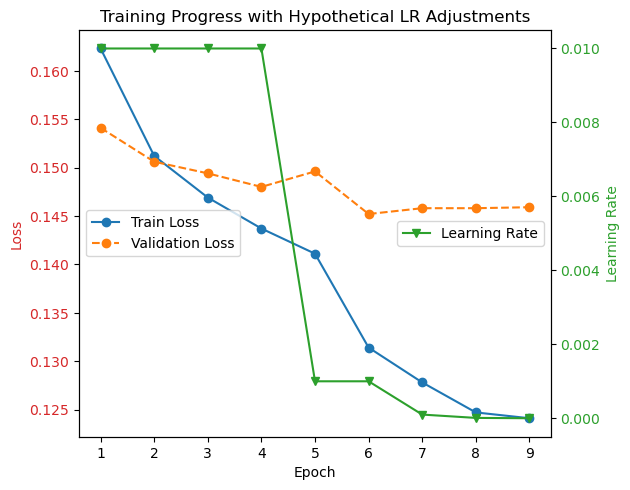

In [3]:
import matplotlib.pyplot as plt

# Epoch and loss data
epochs = range(1, 10)
train_loss = [0.1623, 0.1512, 0.1469, 0.1437, 0.1411, 0.1314, 0.1278, 0.1247, 0.1241]
val_loss = [0.1541, 0.1506, 0.1494, 0.1480, 0.1496, 0.1452, 0.1458, 0.1458, 0.1459]

# Initial learning rate
lr = 0.01
learning_rates = [lr]

# Hypothetical learning rate adjustments
for i in range(1, len(val_loss)):
    if val_loss[i] >= val_loss[i-1]:  # Condition for learning rate decay
        lr /= 10
    learning_rates.append(lr)

# Plotting
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, train_loss, label='Train Loss', color='tab:blue', marker='o')
ax1.plot(epochs, val_loss, label='Validation Loss', color='tab:orange', marker='o', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='center left')

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(epochs, learning_rates, label='Learning Rate', color=color, marker='v', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='center right')

fig.tight_layout()
plt.title('Training Progress with Hypothetical LR Adjustments')
plt.show()


### Accuracy Precision Recall F1-Score

In [4]:
# Re-importing necessary libraries and reloading the data for completeness and troubleshooting

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Load the predictions and actual labels
preds_data = pd.read_csv('D:/School/Major-Project--DEREK/Major-Project-CXR/pretrained/preds.csv') 
labels_data = pd.read_csv('D:/School/Major-Project--DEREK/Major-Project-CXR/nih_labels.csv')

# Merge predictions and actual labels
merged_data = preds_data.merge(labels_data, on='Image Index', how='inner')

# Define conditions and prepare data
condition_columns = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 
    'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
    'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 
    'Pleural_Thickening', 'Hernia'
]

pred_columns = [f'prob_{cond}' for cond in condition_columns]

actual_df = merged_data[condition_columns]
pred_df = merged_data[pred_columns]

binary_pred_df = (pred_df >= 0.5).astype(int)

# Calculate performance metrics
performance_metrics = {}
for condition in condition_columns:
    actual = actual_df[condition]
    pred = binary_pred_df[f'prob_{condition}']
    performance_metrics[condition] = {
        'Accuracy': accuracy_score(actual, pred),
        'Precision': precision_score(actual, pred, zero_division=0),
        'Recall': recall_score(actual, pred),
        'F1-Score': f1_score(actual, pred)
    }

performance_metrics_df = pd.DataFrame(performance_metrics).T
performance_metrics_df


,Accuracy,Precision,Recall,F1-Score
Atelectasis,0.891722,0.495924,0.150640,0.231086
Cardiomegaly,0.973477,0.473684,0.201031,0.282268
Effusion,0.891544,0.582948,0.411829,0.482671
Infiltration,0.823608,0.489891,0.079868,0.137345
Mass,0.947042,0.457539,0.231782,0.307692
Nodule,0.940668,0.509259,0.123411,0.198675
Pneumonia,0.988410,0.000000,0.000000,0.000000
Pneumothorax,0.952213,0.523035,0.177227,0.264746
Consolidation,0.957384,0.666667,0.002090,0.004167
Edema,0.980297,0.204082,0.024213,0.043290


### ROC and Precision-Recall and CM

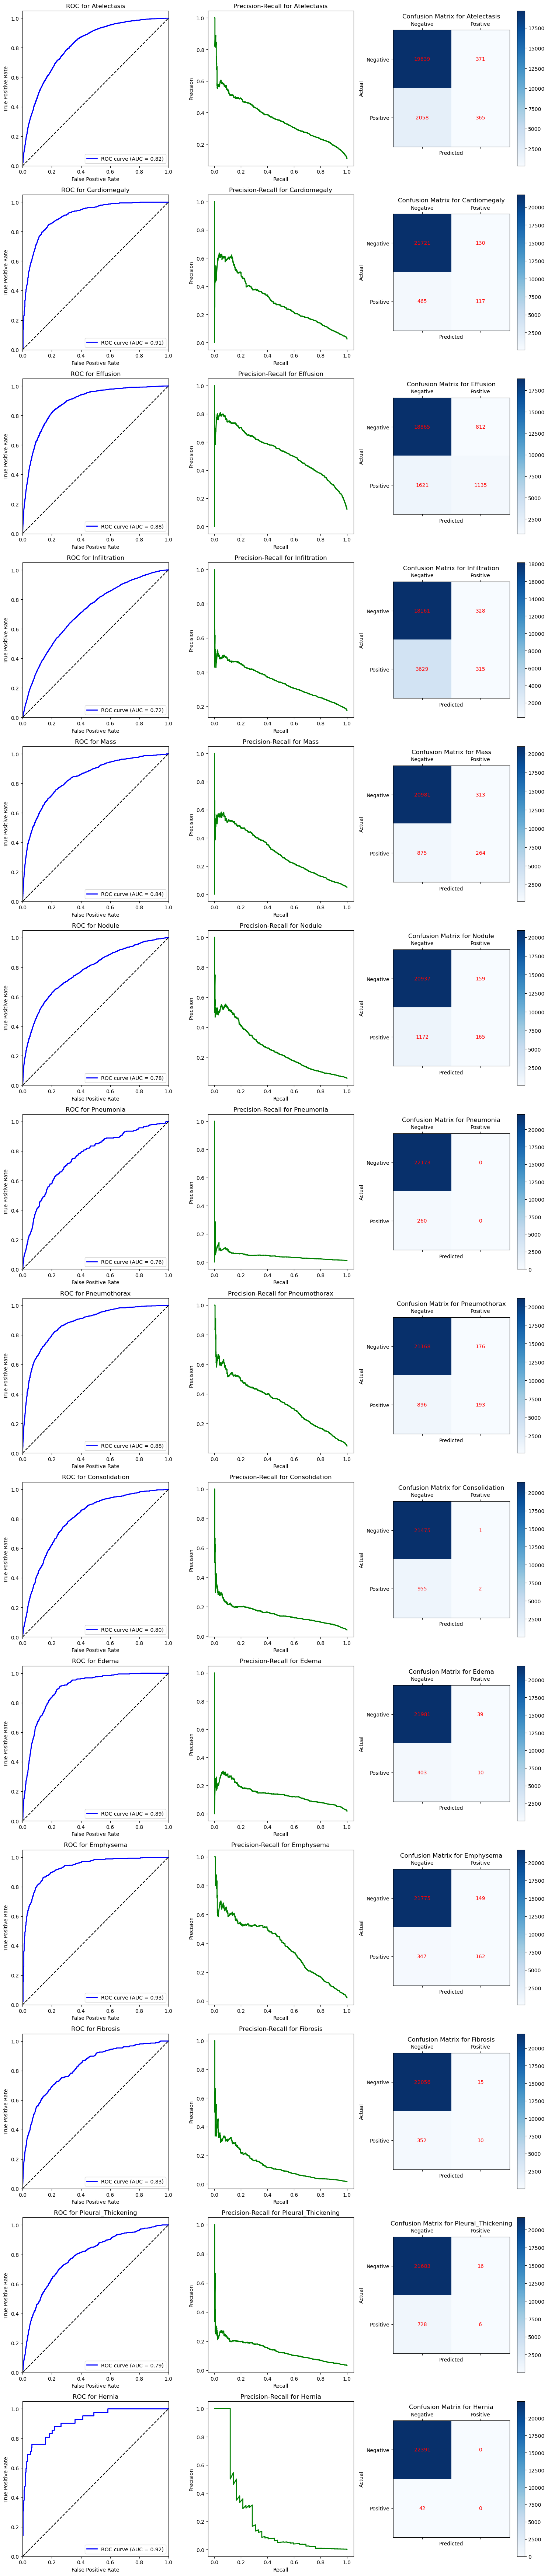

In [5]:
# Generate metrics and plots for a subset of conditions
subset_conditions = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 
    'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
    'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 
    'Pleural_Thickening', 'Hernia'
]

# Function to create plots for the subset
def plot_subset_metrics(actual_df, pred_df, conditions):
    num_conditions = len(conditions)
    fig, axes = plt.subplots(num_conditions, 3, figsize=(15, 5 * num_conditions))

    for i, condition in enumerate(conditions):
        actual = actual_df[condition]
        pred_prob = pred_df[f'prob_{condition}']
        pred_binary = binary_pred_df[f'prob_{condition}']

        # ROC Curve
        fpr, tpr, _ = roc_curve(actual, pred_prob)
        roc_auc = auc(fpr, tpr)
        axes[i, 0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        axes[i, 0].plot([0, 1], [0, 1], 'k--')
        axes[i, 0].set_xlim([0.0, 1.0])
        axes[i, 0].set_ylim([0.0, 1.05])
        axes[i, 0].set_xlabel('False Positive Rate')
        axes[i, 0].set_ylabel('True Positive Rate')
        axes[i, 0].set_title(f'ROC for {condition}')
        axes[i, 0].legend(loc="lower right")

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(actual, pred_prob)
        axes[i, 1].plot(recall, precision, color='green', lw=2)
        axes[i, 1].set_xlabel('Recall')
        axes[i, 1].set_ylabel('Precision')
        axes[i, 1].set_title(f'Precision-Recall for {condition}')

        # Confusion Matrix
        cm = confusion_matrix(actual, pred_binary)
        cax = axes[i, 2].matshow(cm, cmap=plt.cm.Blues)
        fig.colorbar(cax, ax=axes[i, 2])
        axes[i, 2].set_title(f'Confusion Matrix for {condition}')
        axes[i, 2].set_xlabel('Predicted')
        axes[i, 2].set_ylabel('Actual')
        # Before setting labels, set the tick locations explicitly
        axes[i, 2].set_xticks([0, 1])  # Assuming binary classification
        axes[i, 2].set_yticks([0, 1])

        # Now set the tick labels
        axes[i, 2].set_xticklabels(['Negative', 'Positive'])
        axes[i, 2].set_yticklabels(['Negative', 'Positive'])


        # Annotate Confusion Matrix
        for (j, k), val in np.ndenumerate(cm):
            axes[i, 2].text(k, j, f'{val}', ha='center', va='center', color='red')

    plt.tight_layout()
    return fig

# Plot metrics for the subset of conditions
subset_fig = plot_subset_metrics(actual_df, pred_df, subset_conditions)
plt.show()


### ROC Curves for All Conditions

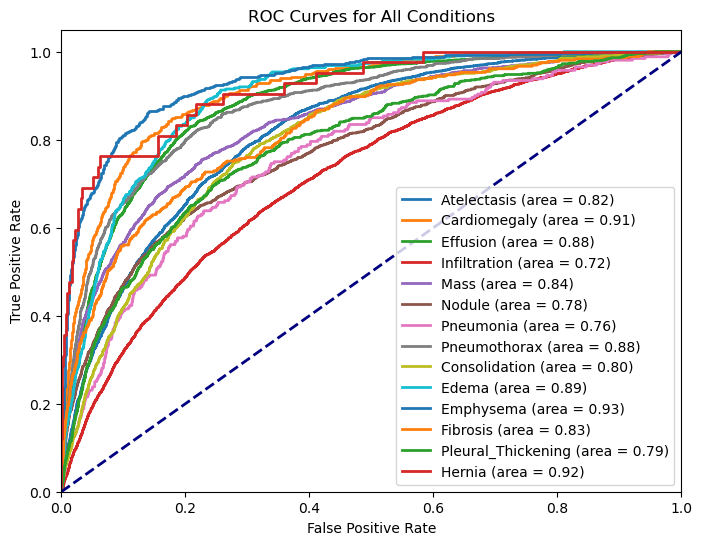

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'actual_df' is your actual labels and 'pred_df' is your predicted probabilities
fig, ax = plt.subplots(figsize=(8, 6))

# Calculate and plot ROC for each condition
for condition in condition_columns:
    actual = actual_df[condition]
    pred_prob = pred_df[f'prob_{condition}']
    fpr, tpr, _ = roc_curve(actual, pred_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, label=f'{condition} (area = {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves for All Conditions')
ax.legend(loc="lower right")
plt.show()


### Precision-Recall Curves for All Conditions

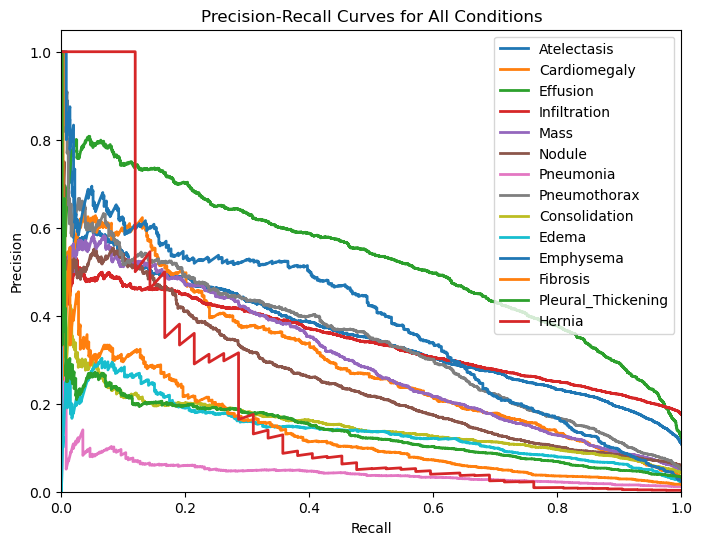

In [7]:
from sklearn.metrics import precision_recall_curve

fig, ax = plt.subplots(figsize=(8, 6))

# Calculate and plot Precision-Recall for each condition
for condition in condition_columns:
    actual = actual_df[condition]
    pred_prob = pred_df[f'prob_{condition}']
    precision, recall, _ = precision_recall_curve(actual, pred_prob)
    ax.plot(recall, precision, lw=2, label=f'{condition}')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim([0.0, 1.05])
ax.set_xlim([0.0, 1.0])
ax.set_title('Precision-Recall Curves for All Conditions')
ax.legend(loc="upper right")
plt.show()


### X